# Lecture practicals

## Week 2
Generate 2-3 synthetic time series with known components.
- Apply classical and STL time series decomposition.
- Review how well components are extracted, compute the mean squared error.

Generate and interpret the ACF plots of the different forms of random walks presented in this lecture.

Reimplement classical decomposition.

Extend lecture 1 exercise with ACF plots and time series decomposition.
- Compare classical and STL decomposition results.
- Interpret ACF plots and time series components.

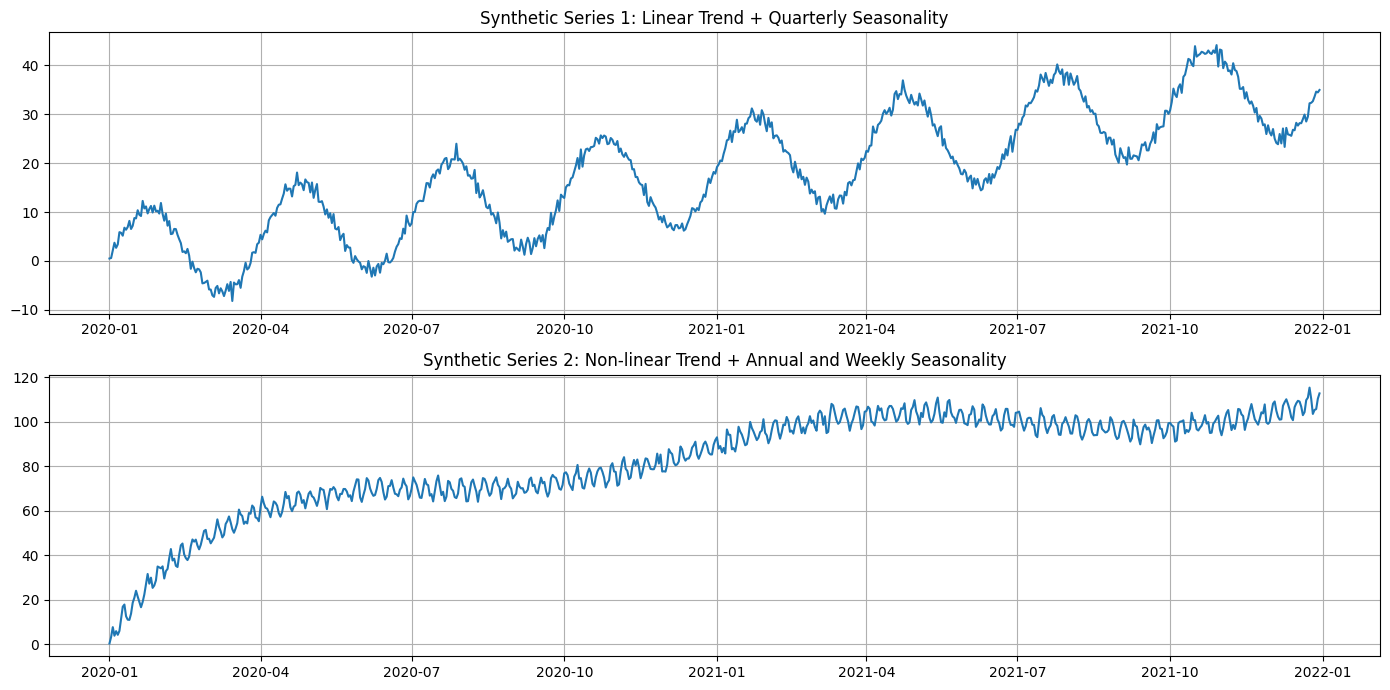

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

np.random.seed(42)

# Generate synthetic time series data with known components
n = 365 * 2
t = np.arange(n)

# Series 1: Linear trend + Single seasonality + Noise
trend1 = 0.05 * t
seasonality1 = 10 * np.sin(2 * np.pi * t / (365 / 4))  # Quartertly seasonality
noise1 = np.random.normal(0, 1, n)
# Combined series
series1 = trend1 + seasonality1 + noise1
series1_components = {'trend': trend1, 'seasonal': seasonality1, 'residual': noise1}

# Series 2: Non-linear trend + Multiple seasonality + Noise
trend2 = 30 * np.log(0.05 * t + 1)
seasonality2 = 8 * np.sin(2 * np.pi * t / 365) + 4 * np.sin(2 * np.pi * t / 7)  # Annual + Weekly
noise2 = np.random.normal(0, 1.5, n)
# Combined series
series2 = trend2 + seasonality2 + noise2
series2_components = {'trend': trend2, 'seasonal': seasonality2, 'residual': noise2}

# Create DataFrames for the time series
dates = pd.date_range(start='2020-01-01', periods=n, freq='D')
synthetic_df = pd.DataFrame({
    'date': dates,
    'series1': series1,
    'series2': series2,
})

# Plot the synthetic time series
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(dates, series1)
plt.title('Synthetic Series 1: Linear Trend + Quarterly Seasonality')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dates, series2)
plt.title('Synthetic Series 2: Non-linear Trend + Annual and Weekly Seasonality')
plt.grid(True)
plt.tight_layout()
plt.show()


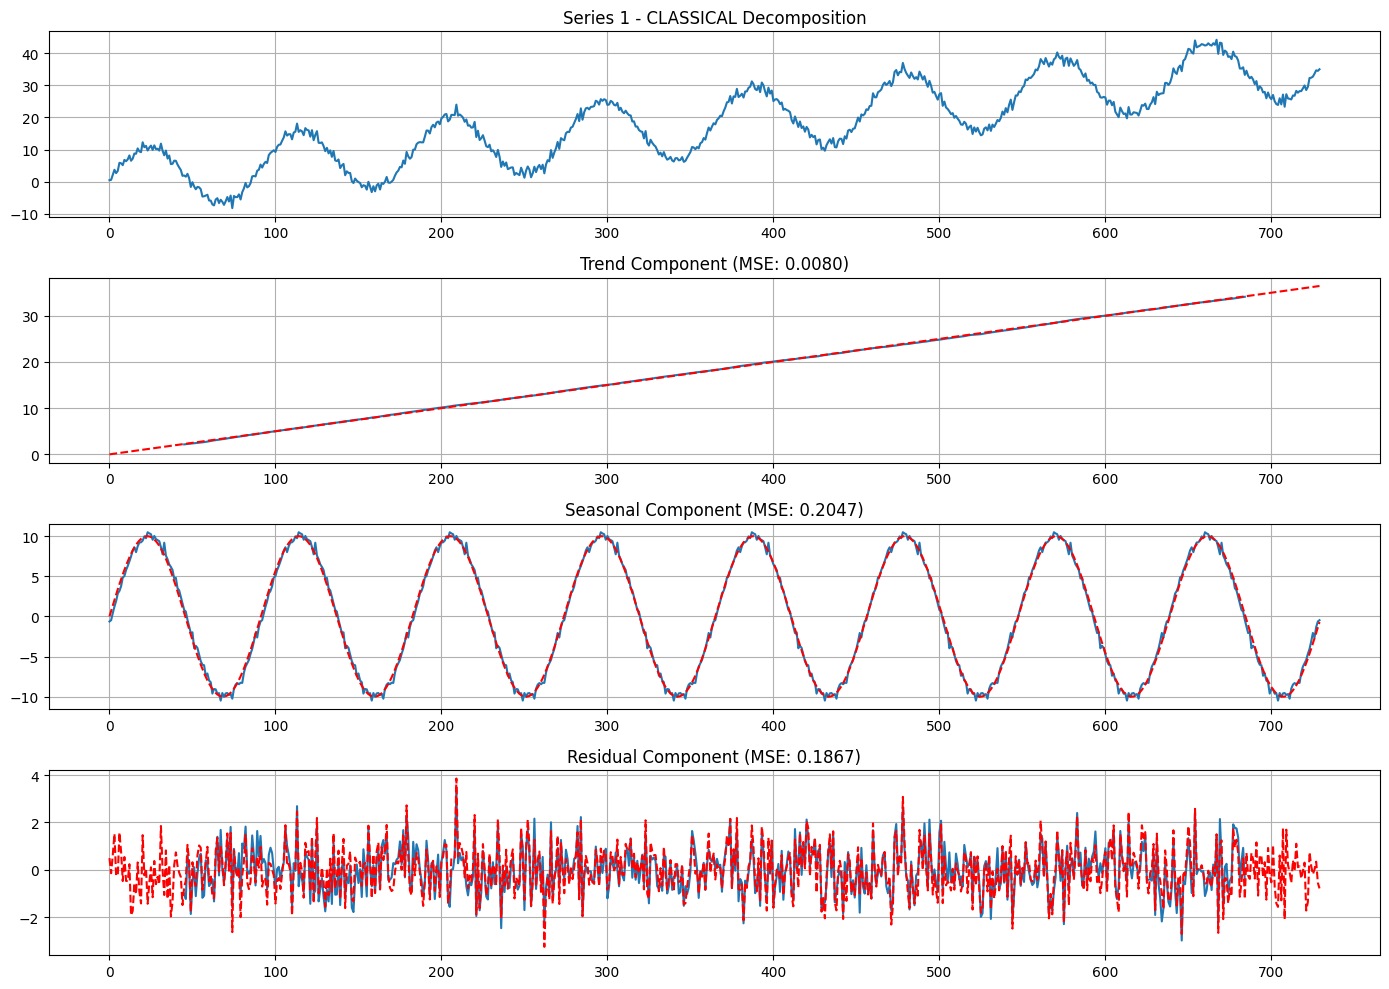

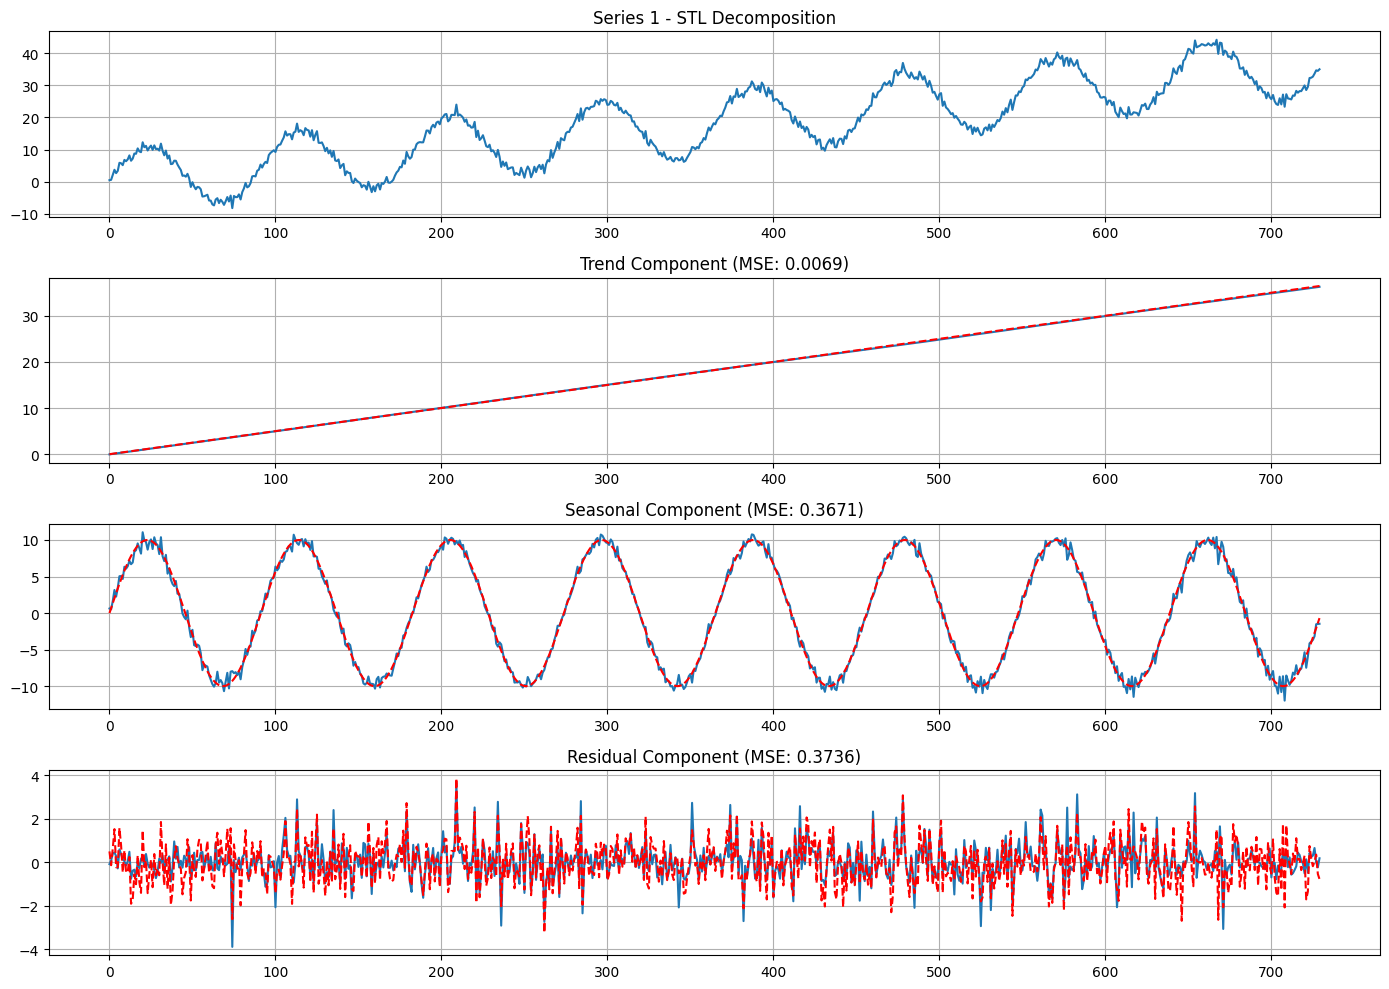

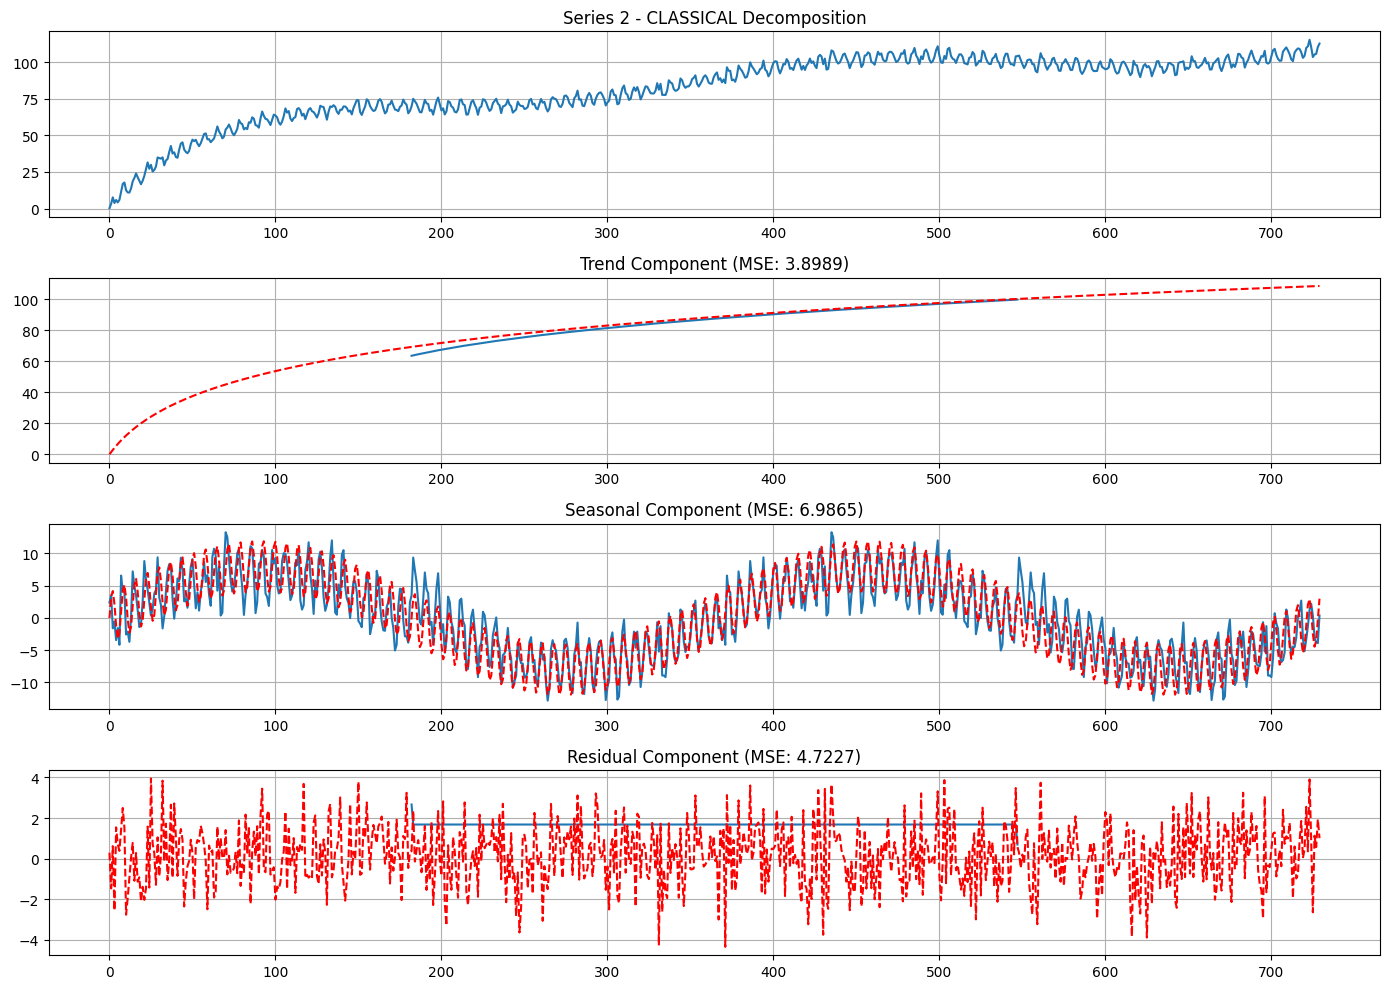

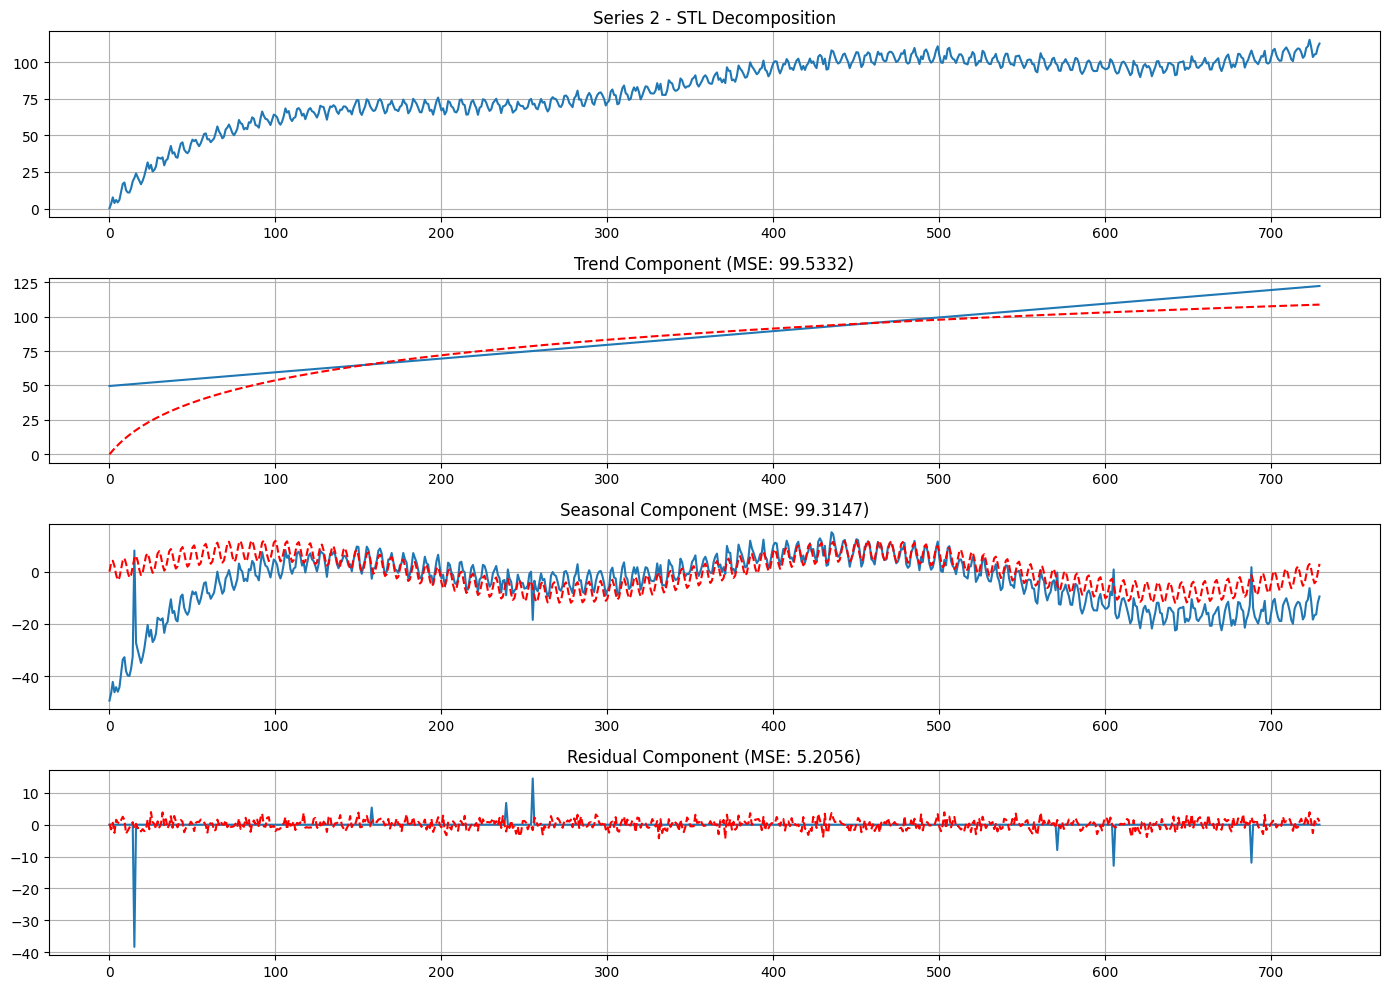

MSE Comparison for Series 1:
Classical: Trend=0.0080, Seasonal=0.2047, Residual=0.1867
STL: Trend=0.0069, Seasonal=0.3671, Residual=0.3736

MSE Comparison for Series 2:
Classical: Trend=3.8989, Seasonal=6.9865, Residual=4.7227
STL: Trend=99.5332, Seasonal=99.3147, Residual=5.2056


In [21]:
def compute_component_mse(true_component, estimated_component):
    """Compute MSE on the shared valid (non-NaN) window between two components."""
    true_arr = np.asarray(true_component)
    est_arr = np.asarray(estimated_component)
    valid_mask = ~np.isnan(true_arr) & ~np.isnan(est_arr)
    if not np.any(valid_mask):
        raise ValueError("No overlapping valid values available to compute MSE.")
    return mean_squared_error(true_arr[valid_mask], est_arr[valid_mask])

def apply_decomposition(series, original_components, method, title='', period=1):
    plt.figure(figsize=(14, 10))
    
    if method == 'classical':
        result = seasonal_decompose(series, model='additive', period=period)
    else:
        result = STL(series, period=period, robust=True).fit()

    result_trend = result.trend
    result_seasonal = result.seasonal
    result_resid = result.resid
    original_trend = original_components['trend']
    original_seasonal = original_components['seasonal']
    original_resid = original_components['residual']

    trend_mse = compute_component_mse(original_trend, result_trend)
    seasonal_mse = compute_component_mse(original_seasonal, result_seasonal)
    residual_mse = compute_component_mse(original_resid, result_resid)
    
    # Plot results
    plt.subplot(4, 1, 1)
    plt.plot(series)
    plt.title(f'{title} - {method.upper()} Decomposition')
    plt.grid(True)
    
    plt.subplot(4, 1, 2)
    plt.plot(result.trend)
    plt.plot(original_components['trend'], 'r--')
    plt.title(f'Trend Component (MSE: {trend_mse:.4f})')
    plt.grid(True)
    
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal)
    plt.plot(original_components['seasonal'], 'r--')
    plt.title(f'Seasonal Component (MSE: {seasonal_mse:.4f})')
    plt.grid(True)
    
    plt.subplot(4, 1, 4)
    plt.plot(result.resid)
    plt.plot(original_components['residual'], 'r--')
    plt.title(f'Residual Component (MSE: {residual_mse:.4f})')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'trend_mse': trend_mse,
        'seasonal_mse': seasonal_mse,
        'residual_mse': residual_mse
    }

# period 365/4 for quarterly seasonality in series1
classical_mse1 = apply_decomposition(series1, series1_components, 'classical', 'Series 1', period=(365 // 4))
stl_mse1 = apply_decomposition(series1, series1_components, 'stl', 'Series 1', period=(365 // 4))

# period 365 for annual seasonality in series2
classical_mse2 = apply_decomposition(series2, series2_components, 'classical', 'Series 2', period=365)
stl_mse2 = apply_decomposition(series2, series2_components, 'stl', 'Series 2', period=365)

# Compare MSE results
print("MSE Comparison for Series 1:")
print(f"Classical: Trend={classical_mse1['trend_mse']:.4f}, Seasonal={classical_mse1['seasonal_mse']:.4f}, Residual={classical_mse1['residual_mse']:.4f}")
print(f"STL: Trend={stl_mse1['trend_mse']:.4f}, Seasonal={stl_mse1['seasonal_mse']:.4f}, Residual={stl_mse1['residual_mse']:.4f}")

print("\nMSE Comparison for Series 2:")
print(f"Classical: Trend={classical_mse2['trend_mse']:.4f}, Seasonal={classical_mse2['seasonal_mse']:.4f}, Residual={classical_mse2['residual_mse']:.4f}")
print(f"STL: Trend={stl_mse2['trend_mse']:.4f}, Seasonal={stl_mse2['seasonal_mse']:.4f}, Residual={stl_mse2['residual_mse']:.4f}")

# Classical decomposition vs STL

The color for the plots is as follows:
Red is original
Blue is the decomposition

Series 1 is rather simple so both methods achieve a near 0 MSE.
Classical decomposition has slightly lower MSE for seasonal and residual components.

Series 2 should be more difficult due to the non linear trend and two seasonal components.
But due to the larger timescale of two years, the second seasonal component weekly is not very noticeable.
Therefore it still mostly the yearly trend
STL has an overall worse MSE than classical decomposition for the Series 2.
Eventhough STL is supposed to be able to capture non linear trends better it did not manage to do it for the somewhat logarithmic trend.
Due to the trend not being removed the seasonality also beings logarithmitically. Therefore worsening the MSE.


Setting the correct period is very important, as demonstrated below:

Wrong period MSE
Classical: Trend=32.9475, Seasonal=40.5529, Residual=10.4977
STL: Trend=31.9939, Seasonal=40.4948, Residual=8.6471
Correct period MSE
Classical: Trend=3.8989, Seasonal=3.7223, Residual=4.7227
STL: Trend=99.5332, Seasonal=99.3147, Residual=5.2056

The MSE is a lot worse when the period parameter is not matched.

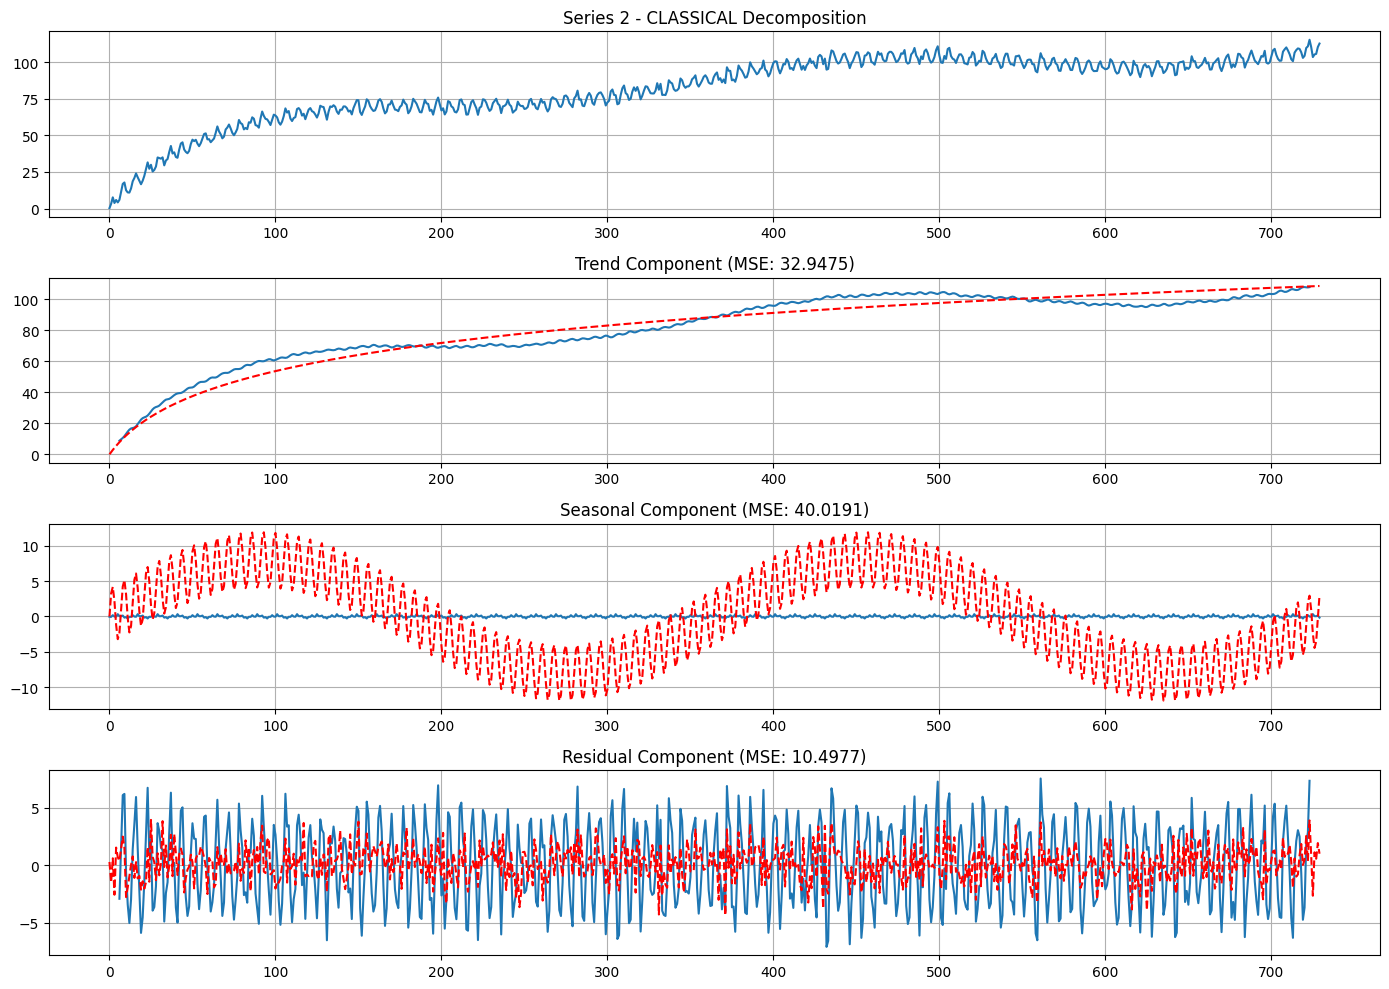

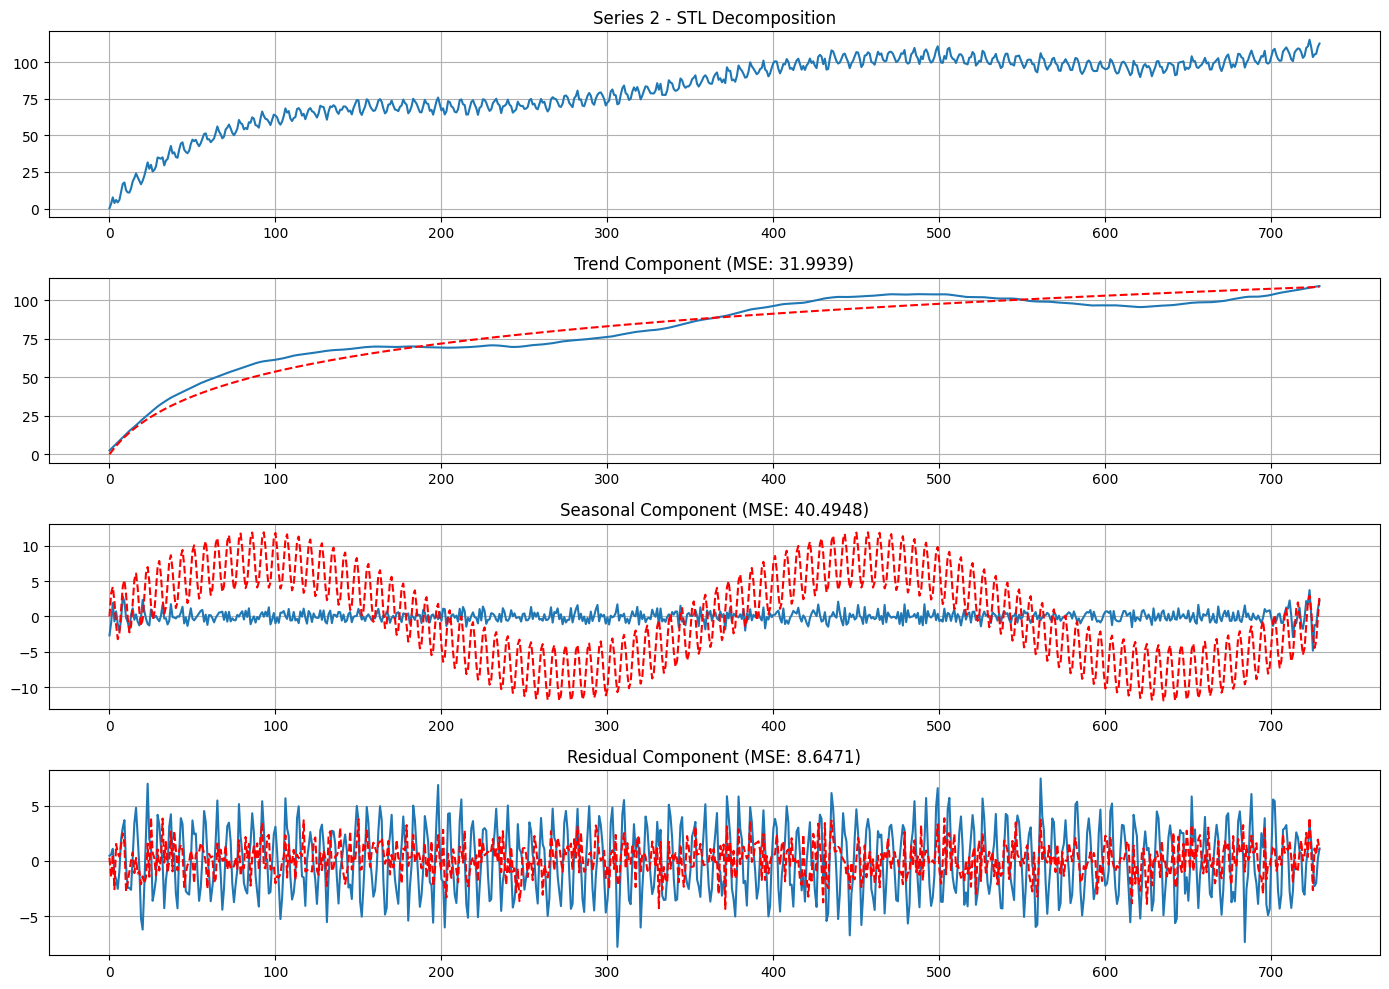


MSE Comparison for Series 2 with period 12:
Classical: Trend=32.9475, Seasonal=40.0191, Residual=10.4977
STL: Trend=31.9939, Seasonal=40.4948, Residual=8.6471


In [22]:
# wrong period 12 for annual seasonality in series2
classical_mse2 = apply_decomposition(series2, series2_components, 'classical', 'Series 2', period=12)
stl_mse2 = apply_decomposition(series2, series2_components, 'stl', 'Series 2', period=12)

print("\nMSE Comparison for Series 2 with period 12:")
print(f"Classical: Trend={classical_mse2['trend_mse']:.4f}, Seasonal={classical_mse2['seasonal_mse']:.4f}, Residual={classical_mse2['residual_mse']:.4f}")
print(f"STL: Trend={stl_mse2['trend_mse']:.4f}, Seasonal={stl_mse2['seasonal_mse']:.4f}, Residual={stl_mse2['residual_mse']:.4f}")

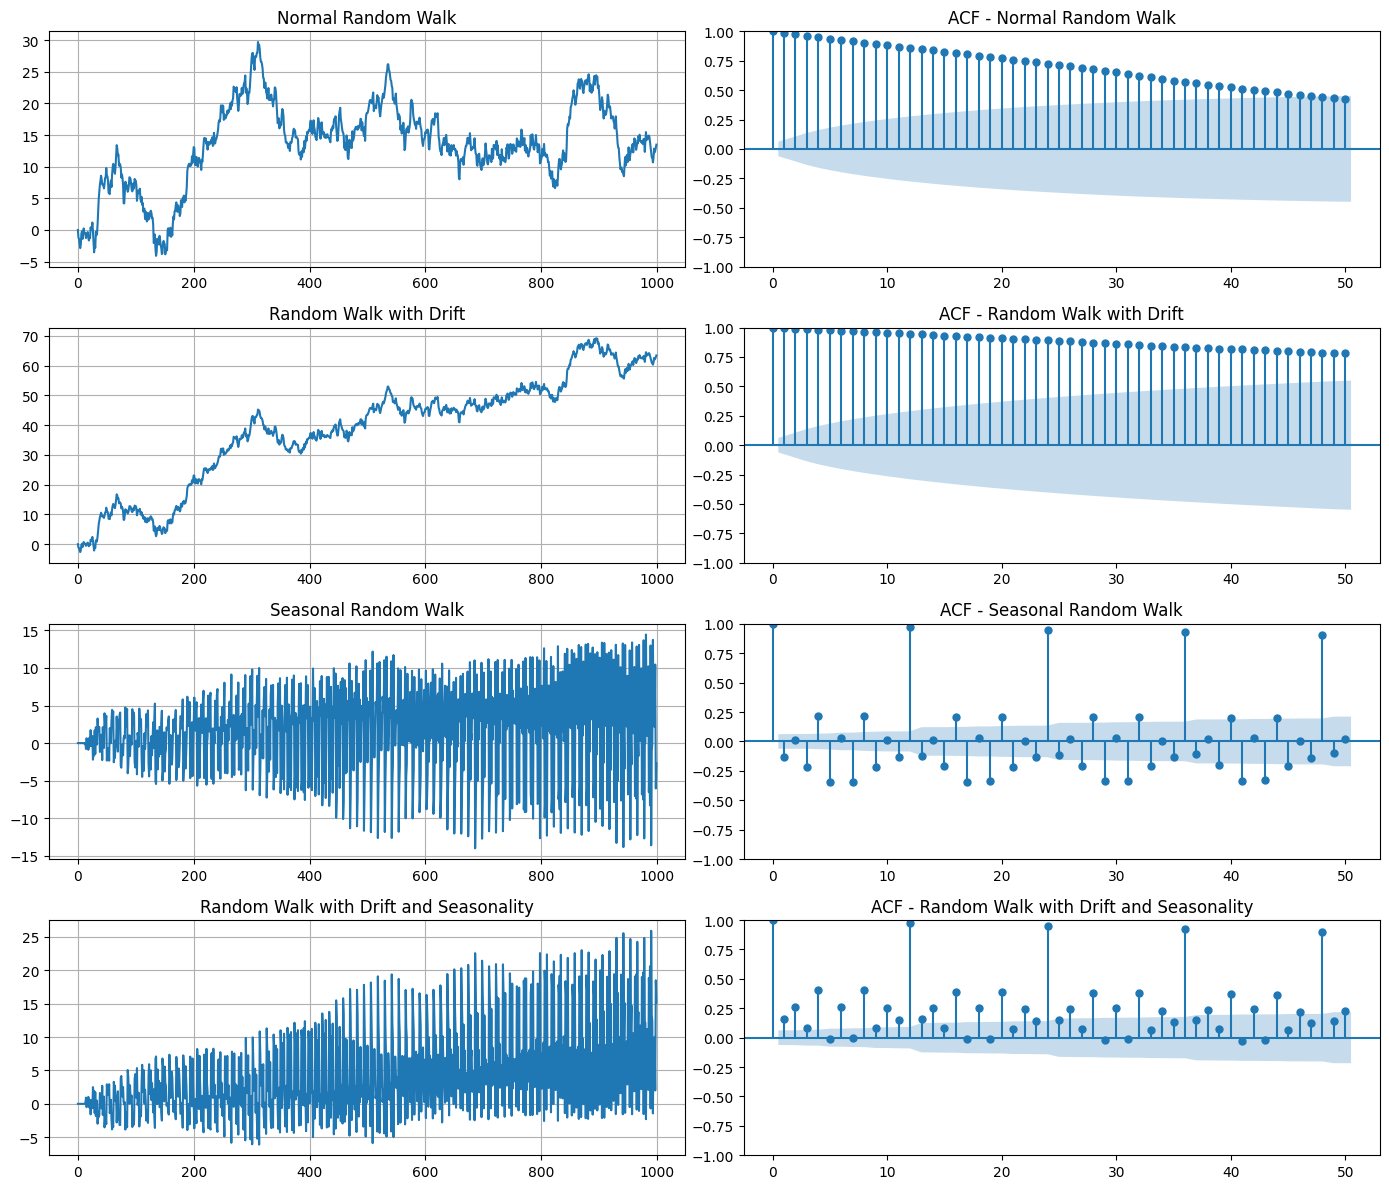

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

n = 1000

# Generate different types of random walks
# 1. Normal random walk: y_t = y_{t-1} + e_t
normal_rw = np.zeros(n)
e = np.random.normal(0, 1, n)
for t in range(1, n):
    normal_rw[t] = normal_rw[t-1] + e[t]

# 2. Random walk with drift: y_t = c + y_{t-1} + e_t
drift = 0.05  # Drift parameter
drift_rw = np.zeros(n)
for t in range(1, n):
    drift_rw[t] = drift + drift_rw[t-1] + e[t]

# 3. Seasonal random walk: y_t = y_{t-s} + e_t
season = 12  # Seasonal period
seasonal_rw = np.zeros(n)
for t in range(season, n):
    seasonal_rw[t] = seasonal_rw[t-season] + e[t]

# 4. Random walk with drift and seasonality: y_t = c + y_{t-1} + y_{t-s} - y_{t-s-1} + e_t
drift_seasonal_rw = np.zeros(n)
for t in range(season+1, n):
    # exaggerate drift, otherwise not visible
    drift_seasonal_rw[t] = (drift*3 + 
                          drift_seasonal_rw[t-season] - 
                          e[t])

# Plot the random walks and their ACF
fig, axes = plt.subplots(4, 2, figsize=(14, 12))

# Normal random walk
axes[0, 0].plot(normal_rw)
axes[0, 0].set_title('Normal Random Walk')
axes[0, 0].grid(True)
plot_acf(normal_rw, lags=50, ax=axes[0, 1], title='ACF - Normal Random Walk')

# Random walk with drift
axes[1, 0].plot(drift_rw)
axes[1, 0].set_title('Random Walk with Drift')
axes[1, 0].grid(True)
plot_acf(drift_rw, lags=50, ax=axes[1, 1], title='ACF - Random Walk with Drift')

# Seasonal random walk
axes[2, 0].plot(seasonal_rw)
axes[2, 0].set_title('Seasonal Random Walk')
axes[2, 0].grid(True)
plot_acf(seasonal_rw, lags=50, ax=axes[2, 1], title='ACF - Seasonal Random Walk')

# Random walk with drift and seasonality
axes[3, 0].plot(drift_seasonal_rw)
axes[3, 0].set_title('Random Walk with Drift and Seasonality')
axes[3, 0].grid(True)
plot_acf(drift_seasonal_rw, lags=50, ax=axes[3, 1], title='ACF - Random Walk with Drift and Seasonality')

plt.tight_layout()
plt.show()

# ACF interpretations
1. Normal Random Walk:
- Slowly decaying ACF showing high persistence
- This is a characteristic of non-stationarity
- Values close to 1 for early lags indicate strong autocorrelation

2. Random Walk with Drift:
- Similar to normal random walk but with a trend component
- ACF shows very high persistence and very slow decay
- Also indicates non-stationarity

3. Seasonal Random Walk:
- ACF shows peaks at seasonal lags (multiples of the seasonal period)
- Indicates non-stationarity with seasonal patterns
- Autocorrelation is especially strong at lags 12, 24, 36, etc.

4. Random Walk with Drift and Seasonality:
- Combines features of both drift and seasonality
- ACF shows both high persistence and seasonal spikes
- Most complex pattern showing trend and seasonal non-stationarity

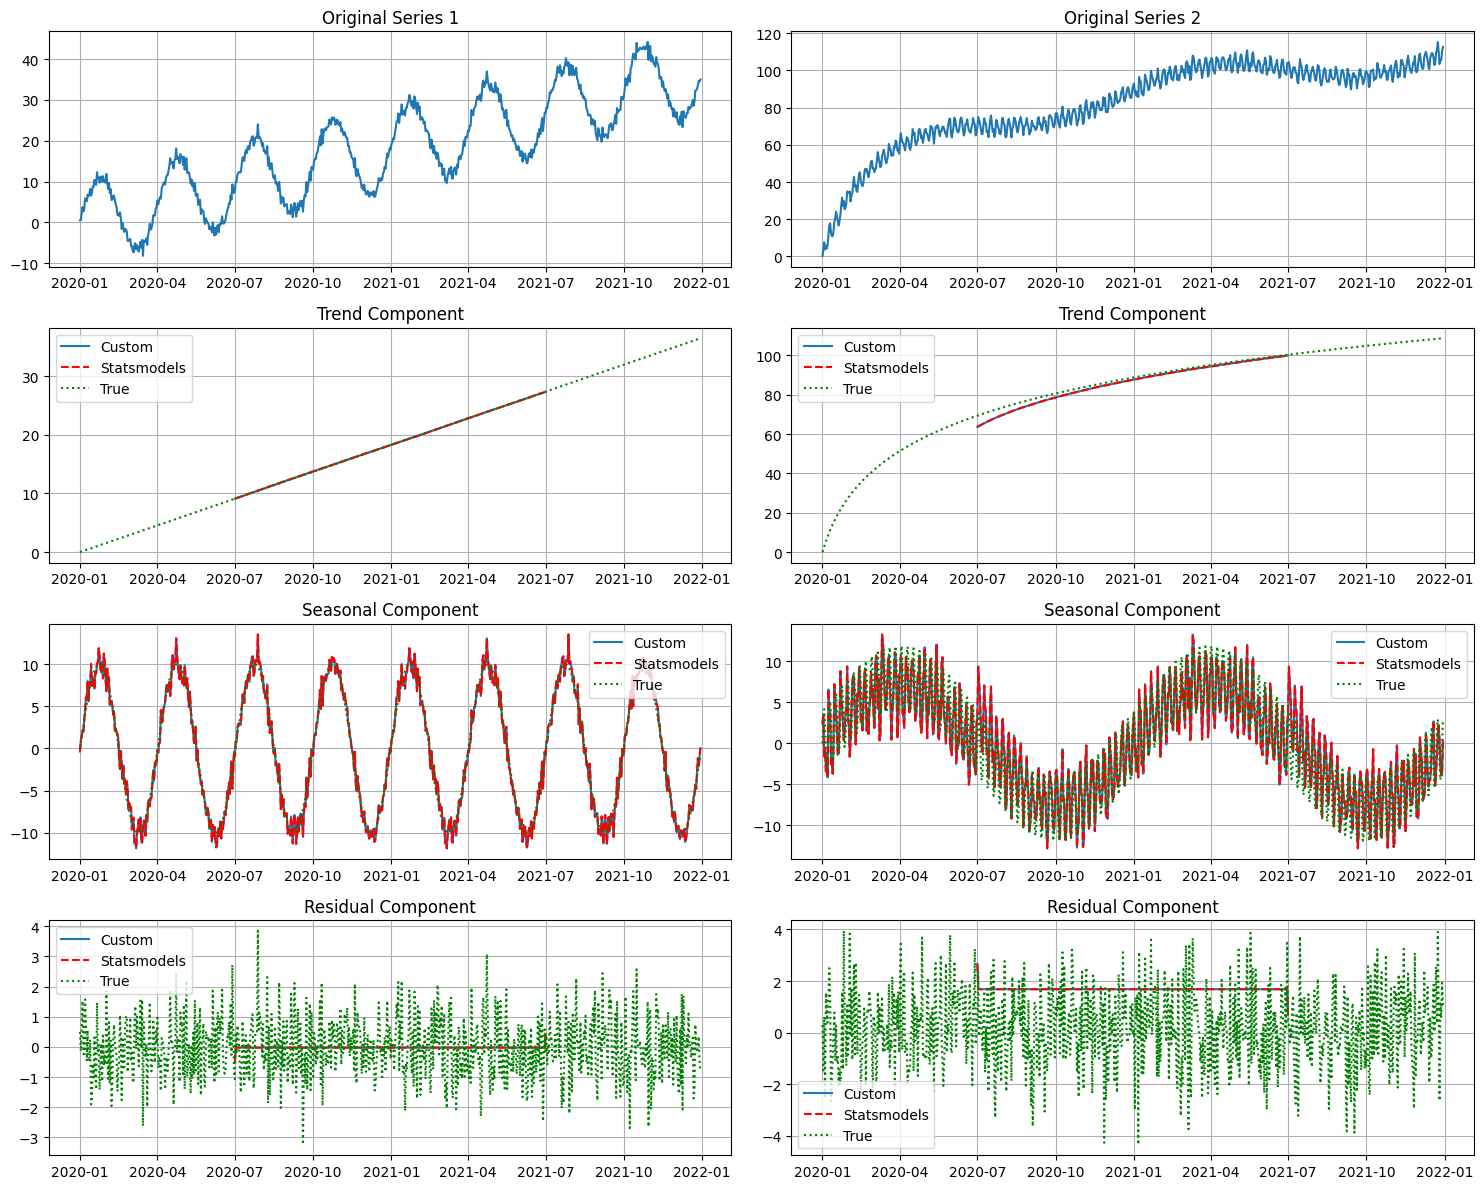

Series 1 - MSE Comparison:
Custom implementation:     Trend: 0.0010, Seasonal: 0.9830, Residual: 0.9839
Statsmodels implementation: Trend: 0.0010, Seasonal: 0.9830, Residual: 0.9839

Series 2 - MSE Comparison:
Custom implementation:     Trend: 3.8989, Seasonal: 6.9865, Residual: 4.7227
Statsmodels implementation: Trend: 3.8989, Seasonal: 6.9865, Residual: 4.7227


In [ ]:
def classical_decomposition(series, period=1):
    """
    Parameters:
    -----------
    series : array-like
        The time series to decompose
    period : int, optional (default=1)
        The period of the seasonality
        
    Returns:
    --------
    dict containing:
        trend : array-like
            The trend component
        seasonal : array-like
            The seasonal component
        resid : array-like
            The residual component
    """
    n = len(series)
    
    # 1: Estimate trend component u, centered moving average
    trend = np.full(n, np.nan)
    k = period // 2
    
    # Handle even and odd periods differently for centered moving average
    if period % 2 == 0:  # Even period
        # Calculate simple moving average first
        ma = np.zeros(n - period + 1)
        for i in range(n - period + 1):
            ma[i] = np.mean(series[i:i+period])
        
        # Calculate centered moving average
        for i in range(n - period):
            trend[i+k] = (ma[i] + ma[i+1]) / 2
    else:  # Odd period
        for i in range(n - period + 1):
            trend[i+k] = np.mean(series[i:i+period])
    
    # 2: Detrend time series d = x - u
    detrended = series - trend
    
    # 3: Estimate seasonal component s
    # 1. group seasonal values
    seasonal_pattern = np.zeros(period)
    for i in range(period):
        group_values = detrended[i::period]
        valid_values = group_values[~np.isnan(group_values)]
        if valid_values.size > 0:
            seasonal_pattern[i] = np.mean(valid_values)
        else:
            seasonal_pattern[i] = 0.0
    # 2. Adjust components to sum to zero
    seasonal_pattern = seasonal_pattern - np.mean(seasonal_pattern)
    # 3. Repeat the seasonal component for each period
    seasonal = np.tile(seasonal_pattern, int(np.ceil(n / period)))[:n]
    
    # 4: Deseasonalize r = d - s
    resid = detrended - seasonal
    
    return {
        'trend': trend,
        'seasonal': seasonal,
        'resid': resid
    }


# Apply custom classical decomposition to series1
custom_result1 = classical_decomposition(series1, period=365)

# Compare with statsmodels
plt.figure(figsize=(15, 12))

# Original series
plt.subplot(4, 2, 1)
plt.plot(synthetic_df['date'], series1)
plt.title('Original Series 1')
plt.grid(True)

# Trend component
plt.subplot(4, 2, 3)
plt.plot(synthetic_df['date'], custom_result1['trend'], label='Custom')
plt.plot(synthetic_df['date'], seasonal_decompose(series1, model='additive', period=365).trend, 'r--', label='Statsmodels')
plt.plot(synthetic_df['date'], series1_components['trend'], 'g:', label='True')
plt.title('Trend Component')
plt.legend()
plt.grid(True)

# Seasonal component
plt.subplot(4, 2, 5)
plt.plot(synthetic_df['date'], custom_result1['seasonal'], label='Custom')
plt.plot(synthetic_df['date'], seasonal_decompose(series1, model='additive', period=365).seasonal, 'r--', label='Statsmodels')
plt.plot(synthetic_df['date'], series1_components['seasonal'], 'g:', label='True')
plt.title('Seasonal Component')
plt.legend()
plt.grid(True)

# Residual component
plt.subplot(4, 2, 7)
plt.plot(synthetic_df['date'], custom_result1['resid'], label='Custom')
plt.plot(synthetic_df['date'], seasonal_decompose(series1, model='additive', period=365).resid, 'r--', label='Statsmodels')
plt.plot(synthetic_df['date'], series1_components['residual'], 'g:', label='True')
plt.title('Residual Component')
plt.legend()
plt.grid(True)

# Apply custom classical decomposition to series2
custom_result2 = classical_decomposition(series2, period=365)

# Compare with statsmodels for series2
# Original series
plt.subplot(4, 2, 2)
plt.plot(synthetic_df['date'], series2)
plt.title('Original Series 2')
plt.grid(True)

# Trend component
plt.subplot(4, 2, 4)
plt.plot(synthetic_df['date'], custom_result2['trend'], label='Custom')
plt.plot(synthetic_df['date'], seasonal_decompose(series2, model='additive', period=365).trend, 'r--', label='Statsmodels')
plt.plot(synthetic_df['date'], series2_components['trend'], 'g:', label='True')
plt.title('Trend Component')
plt.legend()
plt.grid(True)

# Seasonal component
plt.subplot(4, 2, 6)
plt.plot(synthetic_df['date'], custom_result2['seasonal'], label='Custom')
plt.plot(synthetic_df['date'], seasonal_decompose(series2, model='additive', period=365).seasonal, 'r--', label='Statsmodels')
plt.plot(synthetic_df['date'], series2_components['seasonal'], 'g:', label='True')
plt.title('Seasonal Component')
plt.legend()
plt.grid(True)

# Residual component
plt.subplot(4, 2, 8)
plt.plot(synthetic_df['date'], custom_result2['resid'], label='Custom')
plt.plot(synthetic_df['date'], seasonal_decompose(series2, model='additive', period=365).resid, 'r--', label='Statsmodels')
plt.plot(synthetic_df['date'], series2_components['residual'], 'g:', label='True')
plt.title('Residual Component')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate MSE for comparison
custom_trend_mse1 = compute_component_mse(series1_components['trend'], custom_result1['trend'])
custom_seasonal_mse1 = compute_component_mse(series1_components['seasonal'], custom_result1['seasonal'])
custom_resid_mse1 = compute_component_mse(series1_components['residual'], custom_result1['resid'])

statsmodels_result1 = seasonal_decompose(series1, model='additive', period=365)
statsmodels_trend_mse1 = compute_component_mse(series1_components['trend'], statsmodels_result1.trend)
statsmodels_seasonal_mse1 = compute_component_mse(series1_components['seasonal'], statsmodels_result1.seasonal)
statsmodels_resid_mse1 = compute_component_mse(series1_components['residual'], statsmodels_result1.resid)

print("Series 1 - MSE Comparison:")
print(f"Custom implementation:     Trend: {custom_trend_mse1:.4f}, Seasonal: {custom_seasonal_mse1:.4f}, Residual: {custom_resid_mse1:.4f}")
print(f"Statsmodels implementation: Trend: {statsmodels_trend_mse1:.4f}, Seasonal: {statsmodels_seasonal_mse1:.4f}, Residual: {statsmodels_resid_mse1:.4f}")

custom_trend_mse2 = compute_component_mse(series2_components['trend'], custom_result2['trend'])
custom_seasonal_mse2 = compute_component_mse(series2_components['seasonal'], custom_result2['seasonal'])
custom_resid_mse2 = compute_component_mse(series2_components['residual'], custom_result2['resid'])

statsmodels_result2 = seasonal_decompose(series2, model='additive', period=365)
statsmodels_trend_mse2 = compute_component_mse(series2_components['trend'], statsmodels_result2.trend)
statsmodels_seasonal_mse2 = compute_component_mse(series2_components['seasonal'], statsmodels_result2.seasonal)
statsmodels_resid_mse2 = compute_component_mse(series2_components['residual'], statsmodels_result2.resid)

print("\nSeries 2 - MSE Comparison:")
print(f"Custom implementation:     Trend: {custom_trend_mse2:.4f}, Seasonal: {custom_seasonal_mse2:.4f}, Residual: {custom_resid_mse2:.4f}")
print(f"Statsmodels implementation: Trend: {statsmodels_trend_mse2:.4f}, Seasonal: {statsmodels_seasonal_mse2:.4f}, Residual: {statsmodels_resid_mse2:.4f}")

In [18]:
import pandas as pd
df = pd.read_parquet("basel-energy-demand.parquet")
df.head()

timestamp_interval_start timestamp_interval_start_text  stromverbrauch_kwh  \
0 2025-09-30 21:45:00+00:00      2025-09-30T23:45:00+0200           27318.806   
1 2025-09-30 21:30:00+00:00      2025-09-30T23:30:00+0200           27922.965   
2 2025-09-30 21:15:00+00:00      2025-09-30T23:15:00+0200           28249.646   
3 2025-09-30 21:00:00+00:00      2025-09-30T23:00:00+0200           29038.658   
4 2025-09-30 20:45:00+00:00      2025-09-30T22:45:00+0200           30034.410   

   grundversorgte_kunden_kwh  freie_kunden_kwh  year  month  day  weekday  \
0                  12528.324         14790.482  2025      9   30        1   
1                  13122.010         14800.955  2025      9   30        1   
2                  13400.783         14848.863  2025      9   30        1   
3                  14031.674         15006.984  2025      9   30        1   
4                  14801.535         15232.875  2025      9   30        1   

   dayofyear  quarter  weekofyear  
0        273        3          40  
1        273        3          40  
2        273        3          40  
3        273        3          40  
4        273        3          40

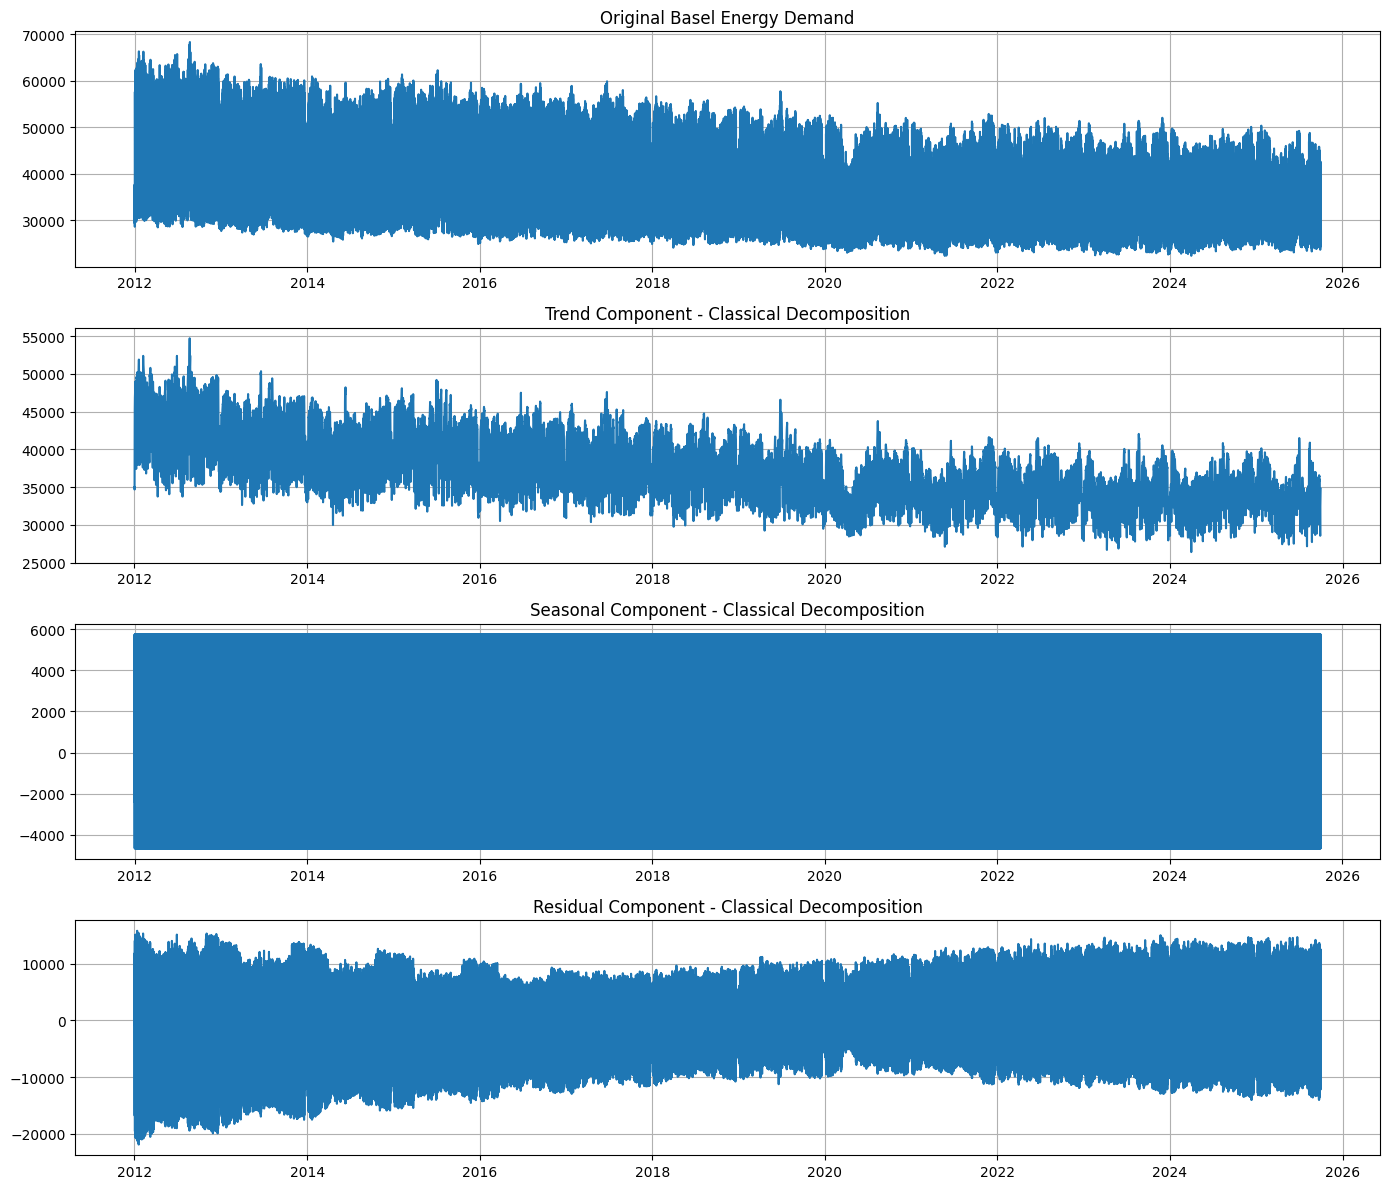

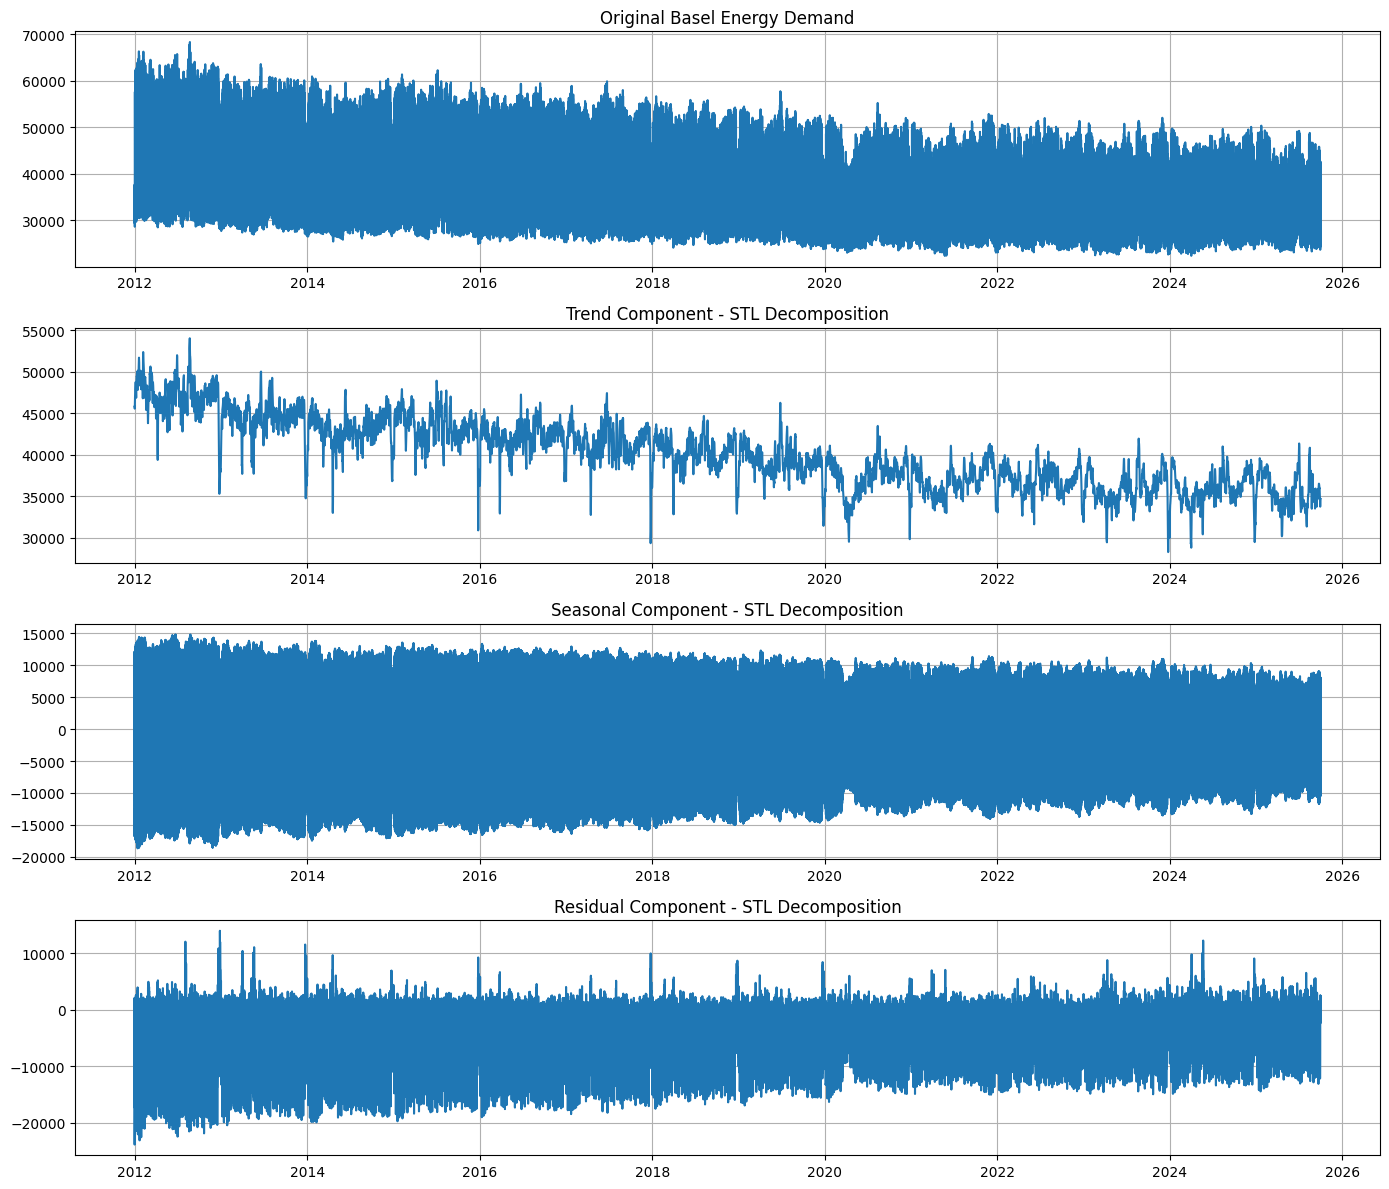

In [19]:

# Apply Classical Decomposition
# Determine frequency: data is recorded every 15 minutes, so daily frequency = 24*4 = 96
# For weekly patterns, use 96*7 = 672
freq = 96  # Daily pattern
classical_result = seasonal_decompose(df['stromverbrauch_kwh'], model='additive', period=freq)

# Apply STL Decomposition
stl_result = STL(df['stromverbrauch_kwh'], period=freq, robust=True).fit()

# Plot Classical Decomposition
plt.figure(figsize=(14, 12))
plt.subplot(4, 1, 1)
plt.plot(df['timestamp_interval_start'], df['stromverbrauch_kwh'])
plt.title('Original Basel Energy Demand')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(df['timestamp_interval_start'], classical_result.trend)
plt.title('Trend Component - Classical Decomposition')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(df['timestamp_interval_start'], classical_result.seasonal)
plt.title('Seasonal Component - Classical Decomposition')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(df['timestamp_interval_start'], classical_result.resid)
plt.title('Residual Component - Classical Decomposition')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot STL Decomposition
plt.figure(figsize=(14, 12))
plt.subplot(4, 1, 1)
plt.plot(df['timestamp_interval_start'], df['stromverbrauch_kwh'])
plt.title('Original Basel Energy Demand')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(df['timestamp_interval_start'], stl_result.trend)
plt.title('Trend Component - STL Decomposition')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(df['timestamp_interval_start'], stl_result.seasonal)
plt.title('Seasonal Component - STL Decomposition')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(df['timestamp_interval_start'], stl_result.resid)
plt.title('Residual Component - STL Decomposition')
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpret timeseries componenets
Classical Decomposition:
- Trend is very noisy, the variance is very high which is visible with the large Y value differences.
- The timeframe is too large for a seasonal component, as the resulting graph is solid. 
- The period might also be wrong, leading to a bad seasonal componenet

STL Decomposition:
- A very clear downward trend component is visible, with small trends inside a year also visible.
- Seasonal component is hard to see, but there are some seaonal peaks and troughs visible on the lower end.
- The residual variance is becoming smaller over the years

## Compare classical and STL decomposition results.
Residual of STL is a lot more stable compared to classical.  This is a result of the better seasonal removal.

<Figure size 1200x500 with 0 Axes>

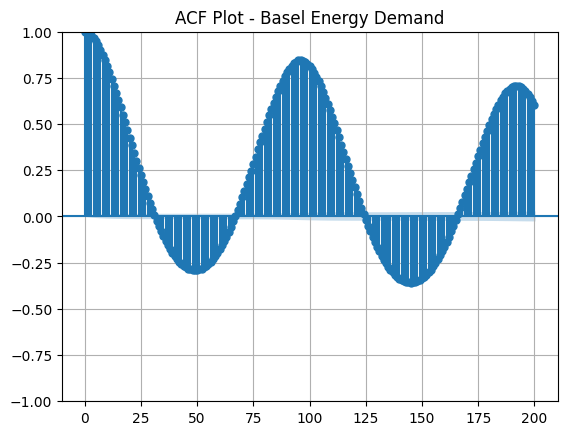

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plot_acf(df['stromverbrauch_kwh'], lags=200, title='ACF Plot - Basel Energy Demand')
plt.grid(True)
plt.show()

## Interpret ACF plots.
ACF Plot Interpretation:
- Both the trend and seasonality are visible
- Seasonality is set to 200, so the daily swings for day/night are visible.
- Generally a trend is also visible, due to the ACF declining